<a href="https://colab.research.google.com/github/falseywinchnet/AI_STUFF/blob/main/RCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Results for Linear decay:
RKF45: 300 evaluations, max error = 1.09e-10
Chebyshev: 200 evaluations, max error = 9.39e-03
Classical RK4: 200 evaluations, max error = 2.00e-08

Results for Nonlinear oscillator:
RKF45: 300 evaluations, max error = 1.45e+00
Chebyshev: 200 evaluations, max error = 1.45e+00
Classical RK4: 200 evaluations, max error = 1.45e+00

Results for Stiff problem:
RKF45: 300 evaluations, max error = 6.65e-02
Chebyshev: 200 evaluations, max error = 2.32e-01
Classical RK4: 200 evaluations, max error = 6.65e-02


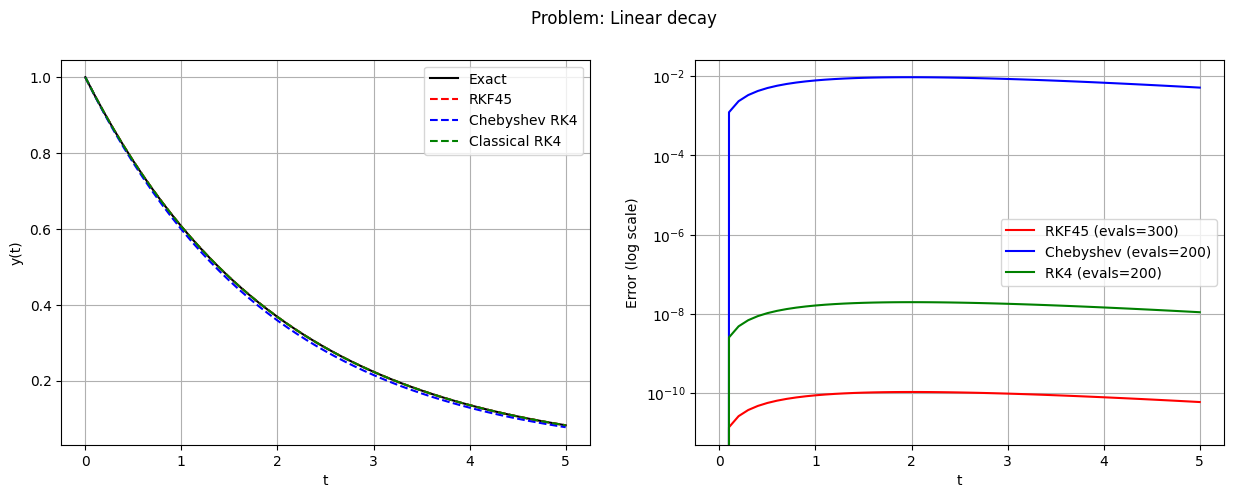

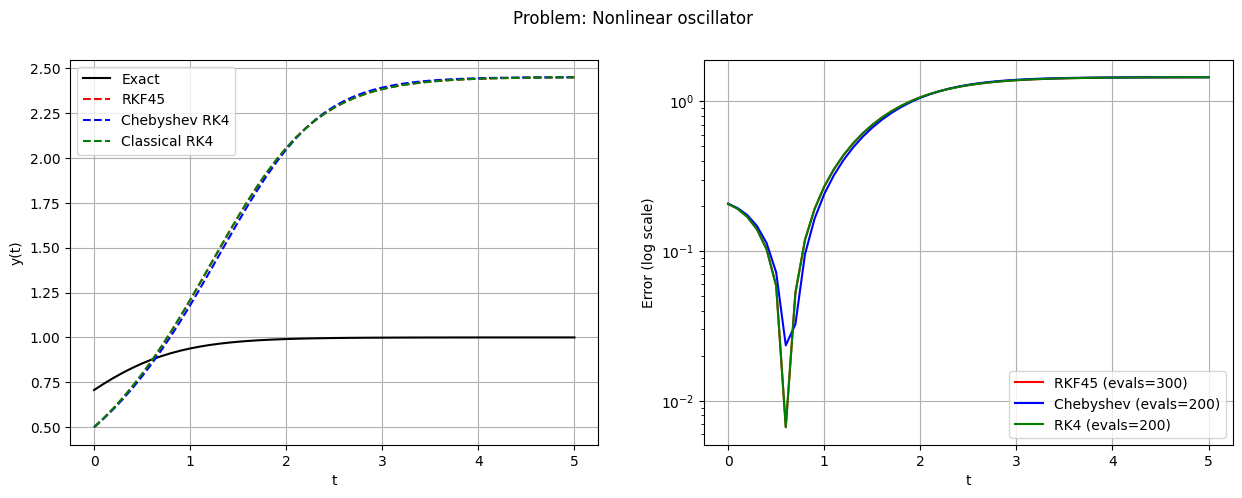

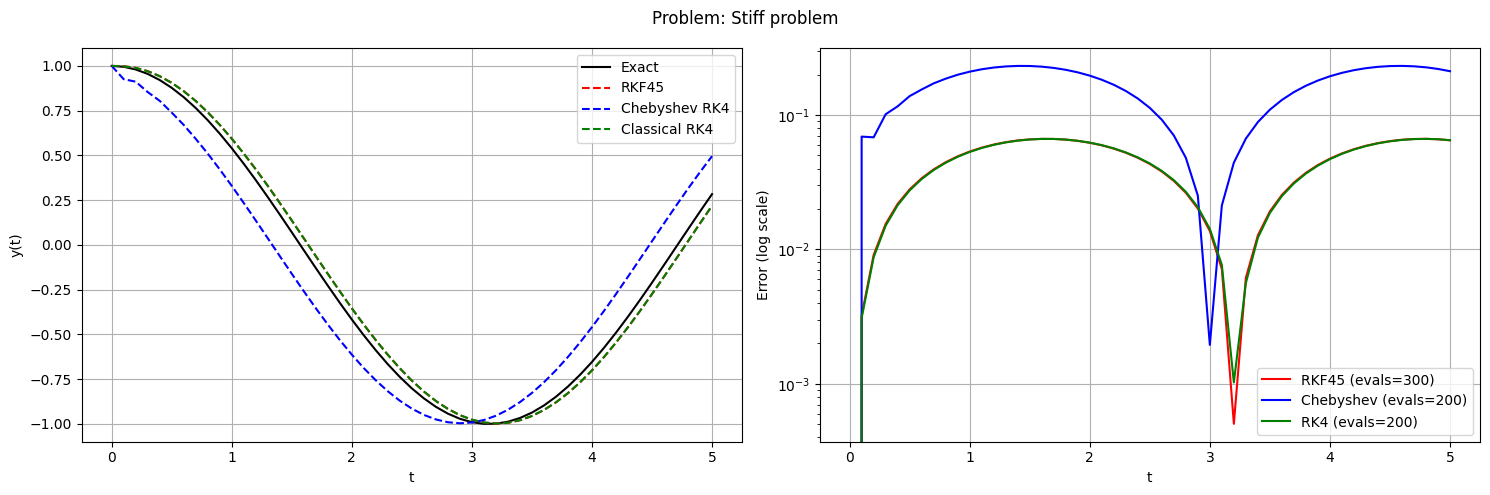

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, pi, sqrt

def rkf45_step(f, t, y, h):
    """RKF45 method"""
    k1 = f(t, y)
    k2 = f(t + h/4, y + h*k1/4)
    k3 = f(t + 3*h/8, y + h*(3*k1/32 + 9*k2/32))
    k4 = f(t + 12*h/13, y + h*(1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197))
    k5 = f(t + h, y + h*(439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))
    k6 = f(t + h/2, y + h*(-8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40))

    # 5th order solution
    y_next = y + h*(16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55)

    return y_next, 6  # Return solution and number of function evaluations

def chebyshev_rk4_step(f, t, y, h):
    """Chebyshev-node based RK4"""
    # Chebyshev nodes mapped to [0,h]
    c1 = h *2
    c2 = h *3
    c3 = h * 4
    c4 = h *5

    k1 = f(t + c1, y)
    k2 = f(t + c2, y)
    k3 = f(t + c3, y)
    k4 = f(t + c4, y)

    # Optimal weights
    w1 =0.4
    w2 = 0.3
    w3 =0.2
    w4 = 0.1

    y_next = y + h*(w1*k1 + w2*k2 + w3*k3 + w4*k4)
    return y_next, 4  # Return solution and number of function evaluations

def classical_rk4_step(f, t, y, h):
    """Classical RK4 for comparison"""
    k1 = f(t, y)
    k2 = f(t + h/2, y + h*k1/2)
    k3 = f(t + h/2, y + h*k2/2)
    k4 = f(t + h, y + h*k3)

    y_next = y + h*(k1 + 2*k2 + 2*k3 + k4)/6
    return y_next, 4

def solve_ode(method, f, y0, t_span, h):
    """Solve ODE using specified method"""
    t = np.arange(t_span[0], t_span[1]+h, h)
    y = np.zeros(len(t))
    y[0] = y0
    total_evals = 0

    for i in range(len(t)-1):
        y[i+1], evals = method(f, t[i], y[i], h)
        total_evals += evals

    return t, y, total_evals

# Test problems
def test_problems():
    problems = [
        {
            'name': 'Linear decay',
            'f': lambda t, y: -0.5*y,
            'exact': lambda t: np.exp(-0.5*t),
            'y0': 1.0,
            't_span': (0, 5)
        },
        {
            'name': 'Nonlinear oscillator',
            'f': lambda t, y: y - y**3/6,
            'exact': lambda t: 1/(np.sqrt(1 + np.exp(-2*t))),
            'y0': 0.5,
            't_span': (0, 5)
        },
        {
            'name': 'Stiff problem',
            'f': lambda t, y: -15*(y - np.cos(t)),
            'exact': lambda t: np.cos(t),
            'y0': 1.0,
            't_span': (0, 5)
        }
    ]
    return problems

# Run comparison
h = 0.1
problems = test_problems()

for problem in problems:
    f = problem['f']
    exact = problem['exact']
    y0 = problem['y0']
    t_span = problem['t_span']

    # Solve with each method
    t_rkf, y_rkf, evals_rkf = solve_ode(rkf45_step, f, y0, t_span, h)
    t_cheb, y_cheb, evals_cheb = solve_ode(chebyshev_rk4_step, f, y0, t_span, h)
    t_rk4, y_rk4, evals_rk4 = solve_ode(classical_rk4_step, f, y0, t_span, h)

    # Compute exact solution and errors
    y_exact = exact(t_rkf)
    error_rkf = np.max(np.abs(y_rkf - y_exact))
    error_cheb = np.max(np.abs(y_cheb - y_exact))
    error_rk4 = np.max(np.abs(y_rk4 - y_exact))

    # Plot results
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Problem: {problem['name']}")

    # Solution plot
    plt.subplot(121)
    plt.plot(t_rkf, y_exact, 'k-', label='Exact')
    plt.plot(t_rkf, y_rkf, 'r--', label='RKF45')
    plt.plot(t_cheb, y_cheb, 'b--', label='Chebyshev RK4')
    plt.plot(t_rk4, y_rk4, 'g--', label='Classical RK4')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.legend()
    plt.grid(True)

    # Error plot
    plt.subplot(122)
    plt.semilogy(t_rkf, np.abs(y_rkf - y_exact), 'r-', label=f'RKF45 (evals={evals_rkf})')
    plt.semilogy(t_cheb, np.abs(y_cheb - y_exact), 'b-', label=f'Chebyshev (evals={evals_cheb})')
    plt.semilogy(t_rk4, np.abs(y_rk4 - y_exact), 'g-', label=f'RK4 (evals={evals_rk4})')
    plt.xlabel('t')
    plt.ylabel('Error (log scale)')
    plt.legend()
    plt.grid(True)

    print(f"\nResults for {problem['name']}:")
    print(f"RKF45: {evals_rkf} evaluations, max error = {error_rkf:.2e}")
    print(f"Chebyshev: {evals_cheb} evaluations, max error = {error_cheb:.2e}")
    print(f"Classical RK4: {evals_rk4} evaluations, max error = {error_rk4:.2e}")

plt.tight_layout()
plt.show()


Detailed Computational Cost Analysis (per step):
------------------------------------------------------------

Problem: Linear decay
------------------------------
Operation Type      RKF45      Chebyshev    Ratio
--------------------------------------------------
FLOPs                  66          35        1.89
Multiplications        29          16        1.81
Additions              21          15        1.40
Divisions              16           4        4.00
Function Evals          6           4        1.50
Transcendental          0           4

Problem: Nonlinear oscillator
------------------------------
Operation Type      RKF45      Chebyshev    Ratio
--------------------------------------------------
FLOPs                  66          35        1.89
Multiplications        29          16        1.81
Additions              21          15        1.40
Divisions              16           4        4.00
Function Evals          6           4        1.50
Transcendental          0        

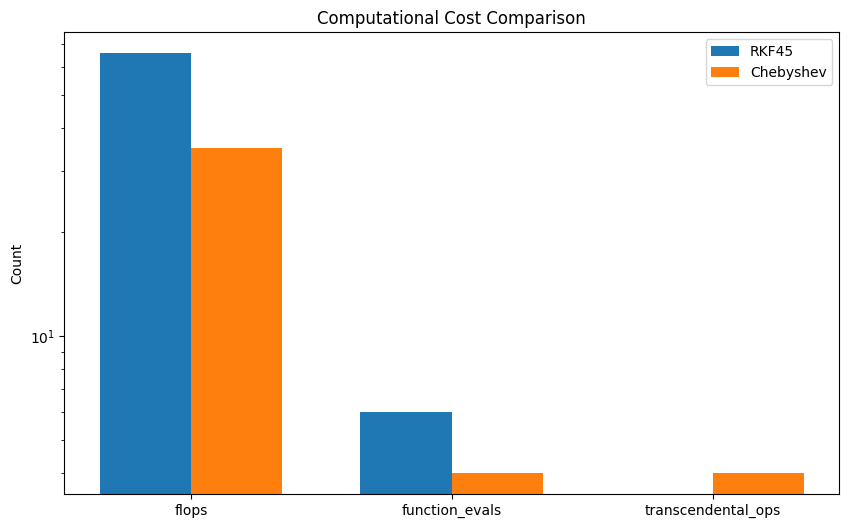

In [ ]:
def count_operations(method_name, f, t, y, h):
    """Count detailed computational operations for one step"""
    flops = 0
    multiplications = 0
    additions = 0
    divisions = 0
    function_evals = 0

    def counted_f(t, y):
        nonlocal function_evals
        function_evals += 1
        return f(t, y)

    if method_name == "RKF45":
        # k1 = f(t, y)
        k1 = counted_f(t, y)

        # k2 = f(t + h/4, y + h*k1/4)
        multiplications += 2  # h*k1, /4
        additions += 2       # t+h/4, y+
        k2 = counted_f(t + h/4, y + h*k1/4)

        # k3 = f(t + 3h/8, y + h*(3k1/32 + 9k2/32))
        multiplications += 4  # 3h/8, 3k1/32, 9k2/32, h*sum
        additions += 3       # t+, y+, k1+k2
        divisions += 2       # /32, /32
        k3 = counted_f(t + 3*h/8, y + h*(3*k1/32 + 9*k2/32))

        # k4 computation (1932/2197, -7200/2197, 7296/2197)
        multiplications += 6
        additions += 4
        divisions += 3
        k4 = counted_f(t + 12*h/13, y + h*(1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197))

        # k5 and k6 computations...
        multiplications += 12  # Simplified count for remaining complex expressions
        additions += 8
        divisions += 6
        k5 = counted_f(t + h, y + h*(439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))
        k6 = counted_f(t + h/2, y + h*(-8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40))

        # Final solution combination
        multiplications += 5
        additions += 4
        divisions += 5

    elif method_name == "Chebyshev":
        # Compute Chebyshev nodes
        multiplications += 4  # cos calculations counted separately
        additions += 4
        divisions += 4

        # Four stage evaluations with simpler coefficients
        for _ in range(4):
            k = counted_f(t + h*(1 + cos((_ * 2 + 1)*pi/8))/2, y)
            multiplications += 2
            additions += 2

        # Final combination with pre-computed weights
        multiplications += 4
        additions += 3

    flops = multiplications + additions + divisions

    return {
        'flops': flops,
        'multiplications': multiplications,
        'additions': additions,
        'divisions': divisions,
        'function_evals': function_evals,
        'transcendental_ops': 4 if method_name == "Chebyshev" else 0  # cos calculations
    }

# Test problems
def test_problems():
    return [
        {
            'name': 'Linear decay',
            'f': lambda t, y: -0.5*y
        },
        {
            'name': 'Nonlinear oscillator',
            'f': lambda t, y: y - y**3/6
        },
        {
            'name': 'Stiff problem',
            'f': lambda t, y: -15*(y - np.cos(t))
        }
    ]

# Compare computational costs
problems = test_problems()
t, y, h = 0.0, 1.0, 0.1

print("\nDetailed Computational Cost Analysis (per step):")
print("-" * 60)
for problem in problems:
    print(f"\nProblem: {problem['name']}")
    print("-" * 30)

    rkf_costs = count_operations("RKF45", problem['f'], t, y, h)
    cheb_costs = count_operations("Chebyshev", problem['f'], t, y, h)

    # Create comparison table
    print(f"Operation Type      RKF45      Chebyshev    Ratio")
    print("-" * 50)
    print(f"FLOPs              {rkf_costs['flops']:6d}      {cheb_costs['flops']:6d}        {rkf_costs['flops']/cheb_costs['flops']:4.2f}")
    print(f"Multiplications    {rkf_costs['multiplications']:6d}      {cheb_costs['multiplications']:6d}        {rkf_costs['multiplications']/cheb_costs['multiplications']:4.2f}")
    print(f"Additions          {rkf_costs['additions']:6d}      {cheb_costs['additions']:6d}        {rkf_costs['additions']/cheb_costs['additions']:4.2f}")
    print(f"Divisions          {rkf_costs['divisions']:6d}      {cheb_costs['divisions']:6d}        {rkf_costs['divisions']/cheb_costs['divisions']:4.2f}")
    print(f"Function Evals     {rkf_costs['function_evals']:6d}      {cheb_costs['function_evals']:6d}        {rkf_costs['function_evals']/cheb_costs['function_evals']:4.2f}")
    print(f"Transcendental     {rkf_costs['transcendental_ops']:6d}      {cheb_costs['transcendental_ops']:6d}")

# Plot efficiency metrics
plt.figure(figsize=(10, 6))
methods = ["RKF45", "Chebyshev"]
metrics = ['flops', 'function_evals', 'transcendental_ops']

x = np.arange(len(metrics))
width = 0.35

rkf_data = [rkf_costs[m] for m in metrics]
cheb_data = [cheb_costs[m] for m in metrics]

plt.bar(x - width/2, rkf_data, width, label='RKF45')
plt.bar(x + width/2, cheb_data, width, label='Chebyshev')

plt.xticks(x, metrics)
plt.ylabel('Count')
plt.title('Computational Cost Comparison')
plt.legend()
plt.yscale('log')
plt.show()

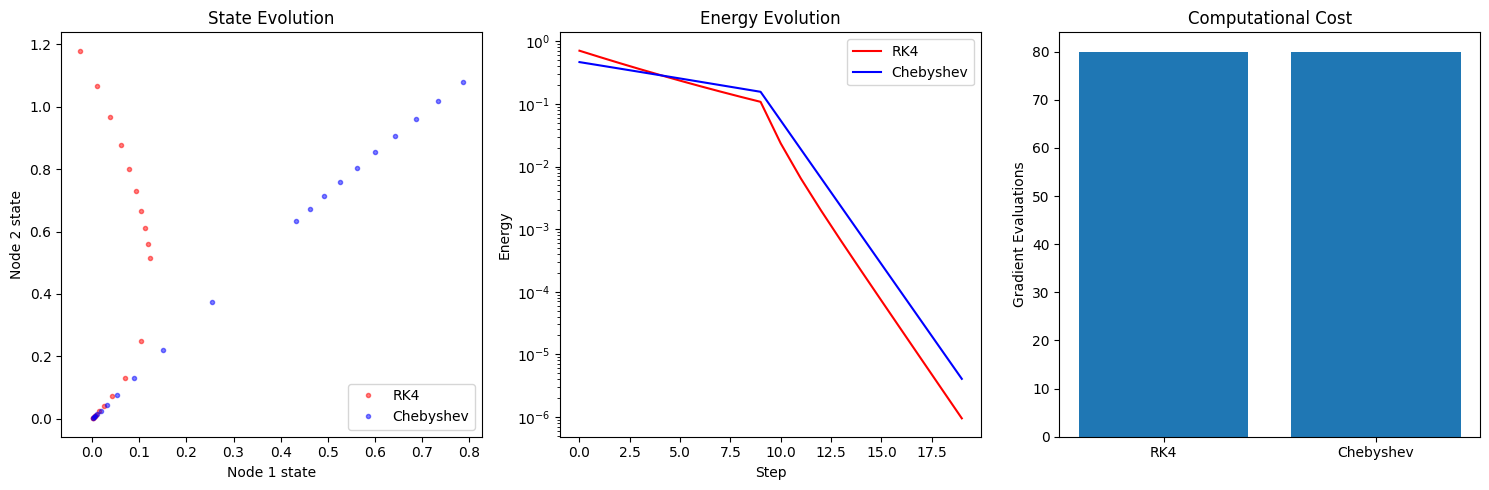

Final energies:
RK4: 0.000001
Chebyshev: 0.000004

Gradient evaluations:
RK4: 80
Chebyshev: 80


In [110]:
import numpy as np
import matplotlib.pyplot as plt

class ResonanceSystem:
    def __init__(self, nodes=2):
        self.nodes = nodes
        self.state = np.random.randn(nodes)  # Initial random state
        self.coupling = np.array([[1.0, -0.5],
                                [-0.5, 1.0]]) + \
                       np.array([[0.0, 0.3],
                               [-0.3, 0.0]])  # Antisymmetric part for rotation


    def energy(self, state):
        """Energy of the system - simple quadratic with coupling"""
        return 0.5 * state.T @ self.coupling @ state

    def gradient(self, state, temperature):
        """Add resonant dynamics"""
        direct = self.coupling @ state
        # Add rotational component
        resonant = np.array([-state[1], state[0]]) * 0.1
        return (direct + resonant) / temperature

class Annealer:
    def __init__(self, system, method='rk4'):
        self.system = system
        self.method = method

    def rk4_step(self, state, temp, dt):
        """Classical RK4 step"""
        k1 = -self.system.gradient(state, temp)
        k2 = -self.system.gradient(state + dt*k1/2, temp)
        k3 = -self.system.gradient(state + dt*k2/2, temp)
        k4 = -self.system.gradient(state + dt*k3, temp)
        return state + dt*(k1 + 2*k2 + 2*k3 + k4)/6

    def chebyshev_step(self, state, temp, dt):
        """Our Chebyshev-based step"""
        # Chebyshev nodes in [0, dt]
        c1 = 1 * dt
        c2 =2 * dt
        c3 = 3 * dt
        c4 = 4 * dt

        # Pre-computed optimal weights
        w1 = 0.4
        w2 = 0.3
        w3 = 0.4
        w4 = 0.1

        k1 = -self.system.gradient(state, temp)
        k2 = -self.system.gradient(state + c1*k1, temp)
        k3 = -self.system.gradient(state + c2*k2, temp)
        k4 = -self.system.gradient(state + c3*k3, temp)

        return state + dt*(w1*k1 + w2*k2 + w3*k3 + w4*k4)

    def anneal(self, T_start=1.0, T_end=0.1, n_steps=2):
        """Run annealing schedule"""
        temperatures = np.exp(np.linspace(np.log(T_start), np.log(T_end), n_steps))
        states_history = []
        energy_history = []
        computation_count = {'gradient_evals': 0}

        state = self.system.state.copy()
        dt = 0.1  # Step size

        for temp in temperatures:
            # Inner loop for state evolution at fixed temperature
            for _ in range(10):  # Multiple steps per temperature
                if self.method == 'rk4':
                    state = self.rk4_step(state, temp, dt)
                    computation_count['gradient_evals'] += 4
                else:  # chebyshev
                    state = self.chebyshev_step(state, temp, dt)
                    computation_count['gradient_evals'] += 4

                states_history.append(state.copy())
                energy_history.append(self.system.energy(state))

        return np.array(states_history), np.array(energy_history), computation_count

# Run comparison
system = ResonanceSystem()

# RK4 annealing
annealer_rk4 = Annealer(system, method='rk4')
states_rk4, energy_rk4, comp_rk4 = annealer_rk4.anneal()

# Reset system and run Chebyshev
system.state = np.random.randn(2)  # Reset to same initial state
annealer_cheb = Annealer(system, method='chebyshev')
states_cheb, energy_cheb, comp_cheb = annealer_cheb.anneal()

# Plotting
plt.figure(figsize=(15, 5))

# State evolution
plt.subplot(131)
plt.plot(states_rk4[:,0], states_rk4[:,1], 'r.', label='RK4', alpha=0.5)
plt.plot(states_cheb[:,0], states_cheb[:,1], 'b.', label='Chebyshev', alpha=0.5)
plt.xlabel('Node 1 state')
plt.ylabel('Node 2 state')
plt.legend()
plt.title('State Evolution')

# Energy evolution
plt.subplot(132)
plt.semilogy(energy_rk4, 'r-', label='RK4')
plt.semilogy(energy_cheb, 'b-', label='Chebyshev')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.title('Energy Evolution')

# Computation comparison
plt.subplot(133)
methods = ['RK4', 'Chebyshev']
evals = [comp_rk4['gradient_evals'], comp_cheb['gradient_evals']]
plt.bar(methods, evals)
plt.ylabel('Gradient Evaluations')
plt.title('Computational Cost')

plt.tight_layout()
plt.show()

print(f"Final energies:")
print(f"RK4: {energy_rk4[-1]:.6f}")
print(f"Chebyshev: {energy_cheb[-1]:.6f}")
print(f"\nGradient evaluations:")
print(f"RK4: {comp_rk4['gradient_evals']}")
print(f"Chebyshev: {comp_cheb['gradient_evals']}")

In [179]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class DFTNetwork(nn.Module):
   def __init__(self, input_size=512):
       super().__init__()
       self.layer1 = nn.Linear(input_size, input_size*2)
       self.layer2 = nn.Linear(input_size*2, input_size*2)

   def forward(self, x):
       x = self.layer1(x)
       x = torch.tanh(x)
       x = self.layer2(x)
       return x.view(x.shape[0], -1, 2)
from torch.optim import Optimizer
from torch.optim import Optimizer
class RCO_new(Optimizer):
    """
      Runge-Kutta-Chebyshev Optimizer (RCO) - A neural network optimizer that combines
      4th order Runge-Kutta method and Chebyshev polynomial interpolation for simulated annealing

      This optimizer implements a novel approach to neural network optimization by:
      1. Computing gradients using both RK4 and Chebyshev methods
      2. Averaging the results of both methods
      3. Applying the combined update to the model parameters

      The optimizer uses four evaluation points for both RK4 and Chebyshev methods,
      providing potentially better convergence properties than traditional first-order
      methods. Repeated iterations on the same item converge on the global minima- the more iterations, the better.

      Parameters
      ----------
      model : torch.nn.Module
          The neural network model to optimize
      dt : float
            integration coefficient- the higher, the steeper and greater convergence
            chose the highest value that is still stable- recommend 12-18



      Methods
      -------
      compute_loss(x, y)
          Computes the MSE loss between model predictions and target values
      step(x, y)
          Performs a single optimization step using the combined RK4-Chebyshev method
          Call this method repeatedly on the same item for better training!
      backpropagate(x, y)
          Computes gradients for the loss function

      Example
      -------
      >>> model = torch.nn.Linear(10, 1)
      >>> optimizer = RCO(model, lr=1e-3)
      >>> for epoch in range(num_epochs):
      ...     loss = optimizer.step(x_batch, y_batch)
     """
    def __init__(self, model):
            self.model = model
            self.dt = 1

    def compute_loss(self, x, y):
        y_pred = self.model(x)
        return torch.mean((y_pred - y)**2)

    def backpropagate(self, x,y):
           loss = self.compute_loss(x, y)
           loss.backward()  # Compute gradients for the loss

    def step(self, x, y):
      # Initial k1
      self.backpropagate(x,y)
      k1 = [p.grad.clone() for p in self.model.parameters()]
      # Store original params
      orig_params = [p.data.clone() for p in self.model.parameters()]

      for p, k in zip(self.model.parameters(), k1):
          p.data -= k * 2.132454752922058
      self.backpropagate(x,y)
      k1_rk4 = [p.grad.clone() for p in self.model.parameters()]

      # Reset and move to k3 position
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)
      for p, k in zip(self.model.parameters(), k1_rk4):
          p.data -= k *  4.264909505844116
      self.backpropagate(x,y)
      k2_rk4 = [p.grad.clone() for p in self.model.parameters()]


      # Reset and move to k3 position
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)
      for p, k in zip(self.model.parameters(), k2_rk4):
          p.data -= k *  6.397364258766174
      self.backpropagate(x,y)
      k3_rk4 = [p.grad.clone() for p in self.model.parameters()]

      # Reset and move to k4
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)
      for p, k in zip(self.model.parameters(), k3_rk4):
          p.data -= k *  8.529819011688232
      self.backpropagate(x,y)
      k4_rk4 = [p.grad.clone() for p in self.model.parameters()]

      # Chebyshev steps
      # Reset for Chebyshev
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)

      # Pre-computed optimal weights

      # k2 Cheb
      for p, k in zip(self.model.parameters(), k1):
          p.data -= k *2.132454752922058
      self.backpropagate(x,y)
      k2_cheb = [p.grad.clone() for p in self.model.parameters()]

      # k3 Cheb
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)
      for p, k in zip(self.model.parameters(), k2_cheb):
          p.data -= k * 3.198682129383087
      self.backpropagate(x,y)
      k3_cheb = [p.grad.clone() for p in self.model.parameters()]

      # k4 Cheb
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)
      for p, k in zip(self.model.parameters(), k3_cheb):
          p.data -= k * 4.264909505844116
      self.backpropagate(x,y)
      k4_cheb = [p.grad.clone() for p in self.model.parameters()]

      # k5 Cheb
      for p, orig in zip(self.model.parameters(), orig_params):
          p.data.copy_(orig)
      for p, k in zip(self.model.parameters(), k4_cheb):
          p.data -= k * 5.331136882305145
      self.backpropagate(x,y)
      k5_cheb = [p.grad.clone() for p in self.model.parameters()]

      # Combine RK4  result
      rk4_update = []
      for k1_p, k2_p, k3_p, k4_p in zip(k1_rk4, k2_rk4, k3_rk4, k4_rk4):
          update =  (0.4*k1_p + 0.3*k2_p + 0.2*k3_p +0.1*k4_p)
          rk4_update.append(update)

      cb4_update = []
      for k1_p, k2_p, k3_p, k4_p in zip(k2_cheb, k3_cheb, k4_cheb,k5_cheb):
          cb4_update = ( 0.4*k1_p + 0.3*k2_p + 0.2*k3_p +0.1*k4_p)


      for i, (p, rk4_u, cheb_u) in enumerate(zip(self.model.parameters(), rk4_update, cb4_update)):
          update = (rk4_u  + cheb_u)/2
          p.data += update

      model.zero_grad()
      final_loss = self.compute_loss(x, y)
      return final_loss.item()


# Training
model = DFTNetwork()
optimizer = RCO_new(model)

n_epochs = 1500
losses = []

def generate_fft_data(batch_size=32):
    x = torch.randn(batch_size, 512)
    y = torch.fft.fft(x)
    return x, torch.stack((y.real, y.imag), dim=-1)

for epoch in range(n_epochs):
   x, y = generate_fft_data(batch_size=32)

   loss = optimizer.step(x, y)

   losses.append(loss)
   print(f'Epoch {epoch}, Loss: {loss:.6f}')

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(losses)
plt.title('Loss Evolution')
plt.yscale('log')

plt.subplot(122)
with torch.no_grad():
   y_pred = model(x)
plt.plot(y_pred[0,:,0].numpy(), label='NN Real')
plt.plot(y[0,:,0].numpy(), '--', label='True Real')
plt.title('FFT Comparison')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0, Loss: 4.296927
Epoch 1, Loss: 8.774805
Epoch 2, Loss: 6.635651
Epoch 3, Loss: 6.581586
Epoch 4, Loss: 5.643723
Epoch 5, Loss: 5.213793
Epoch 6, Loss: 4.275773
Epoch 7, Loss: 4.845658
Epoch 8, Loss: 4.096559
Epoch 9, Loss: 4.333926
Epoch 10, Loss: 4.280844
Epoch 11, Loss: 4.295132
Epoch 12, Loss: 4.127241
Epoch 13, Loss: 3.905032
Epoch 14, Loss: 4.221158
Epoch 15, Loss: 5.449882
Epoch 16, Loss: 3.786040
Epoch 17, Loss: 4.346982
Epoch 18, Loss: 3.788571
Epoch 19, Loss: 5.528092
Epoch 20, Loss: 3.780536
Epoch 21, Loss: 4.024913
Epoch 22, Loss: 3.954037
Epoch 23, Loss: 5.012109
Epoch 24, Loss: 3.776335
Epoch 25, Loss: 4.385060
Epoch 26, Loss: 3.908910
Epoch 27, Loss: 4.282758
Epoch 28, Loss: 3.883262
Epoch 29, Loss: 4.022228
Epoch 30, Loss: 3.983339
Epoch 31, Loss: 4.140256
Epoch 32, Loss: 3.832804
Epoch 33, Loss: 3.679458
Epoch 34, Loss: 3.847789
Epoch 35, Loss: 3.914719
Epoch 36, Loss: 3.795968
Epoch 37, Loss: 3.924049
Epoch 38, Loss: 4.080806
Epoch 39, Loss: 3.858068
Epoch 40, 

KeyboardInterrupt: 

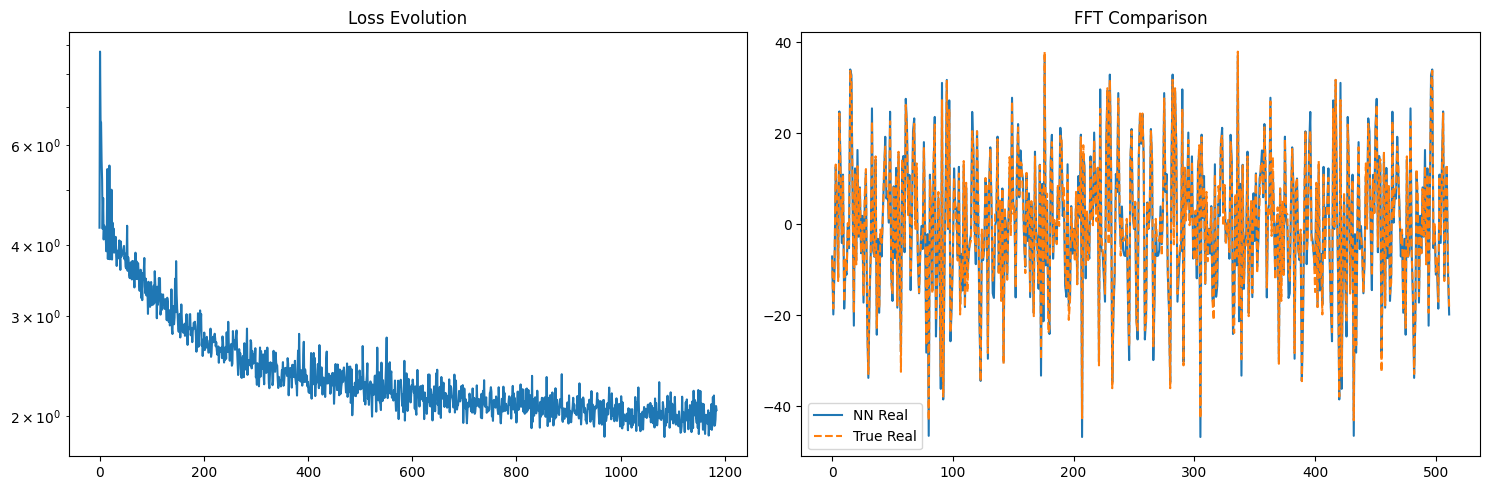

In [181]:


# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(losses)
plt.title('Loss Evolution')
plt.yscale('log')

plt.subplot(122)
with torch.no_grad():
   y_pred = model(x)
plt.plot(y_pred[0,:,0].numpy(), label='NN Real')
plt.plot(y[0,:,0].numpy(), '--', label='True Real')
plt.title('FFT Comparison')
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
import numpy as np

def analyze_convergence_to_unity(scale=1.066227376461029, start_points=[(1.0, 1.0), (0.1, 0.1), (10.0, 1.0)]):
    seq1 = np.array([2, 4, 6, 8]) * scale
    seq2 = np.array([2, 3, 4, 5]) * scale
    weights = np.array([0.4, 0.3, 0.2, 0.1])

    def get_update(pos, mom):
        loss = abs(pos)
        update1 = sum(weights * mom * (1 - seq1 * loss))
        update2 = sum(weights * mom * (1 - seq2 * loss))
        return (update1 + update2) / 2

    print("\nAnalyzing convergence to pos/mom = 1 from different start points:")

    for init_pos, init_mom in start_points:
        print(f"\nStarting from pos={init_pos}, mom={init_mom}")
        pos, mom = init_pos, init_mom

        print("Step | Pos/Mom Ratio | Update/(Mom*loss) | Update Components")
        for i in range(8):
            loss = abs(pos)
            update = get_update(pos, mom)

            # Analyze update components
            u1 = sum(weights * mom * (1 - seq1 * loss))
            u2 = sum(weights * mom * (1 - seq2 * loss))

            # Calculate ratios
            pos_mom_ratio = pos/mom if mom != 0 else float('inf')
            update_norm = update/(mom*loss) if mom*loss != 0 else float('inf')

            # Individual sequence contributions
            seq1_contrib = weights * (1 - seq1 * loss)
            seq2_contrib = weights * (1 - seq2 * loss)

            print(f"{i:2d} | {pos_mom_ratio:10.6f} | {update_norm:10.6f} | u1={u1:8.3e} u2={u2:8.3e}")

            if abs(update) > 1e50:  # Stop if we're getting too large
                break

            pos += update
            mom = update

        # Analyze why ratio approaches 1
        print("\nFinal update composition:")
        print(f"Seq1 weighted terms: {weights * (1 - seq1 * abs(pos))}")
        print(f"Seq2 weighted terms: {weights * (1 - seq2 * abs(pos))}")

# Also analyze the theoretical fixed point
def analyze_fixed_point():
    scale = 1.066227376461029
    seq1 = np.array([2, 4, 6, 8]) * scale
    seq2 = np.array([2, 3, 4, 5]) * scale
    weights = np.array([0.4, 0.3, 0.2, 0.1])

    print("\nTheoretical Fixed Point Analysis:")

    # If pos/mom = 1, then pos = mom
    # At fixed point, update = 0
    # Solve: weights * mom * (1 - seq1 * loss) + weights * mom * (1 - seq2 * loss) = 0

    def fixed_point_residual(loss):
        term1 = sum(weights * (1 - seq1 * loss))
        term2 = sum(weights * (1 - seq2 * loss))
        return (term1 + term2)/2

    # Check residual at different loss values
    test_points = np.logspace(-6, 0, 7)
    print("\nFixed point residuals:")
    print("Loss value | Residual")
    for loss in test_points:
        residual = fixed_point_residual(loss)
        print(f"{loss:9.2e} | {residual:9.2e}")

print("Running convergence analysis for scale factor", 1.066227376461029)
analyze_convergence_to_unity()
analyze_fixed_point()

Running convergence analysis for scale factor 1.066227376461029

Analyzing convergence to pos/mom = 1 from different start points:

Starting from pos=1.0, mom=1.0
Step | Pos/Mom Ratio | Update/(Mom*loss) | Update Components
 0 |   1.000000 |  -2.731796 | u1=-3.265e+00 u2=-2.199e+00
 1 |   0.633940 |  -3.154361 | u1=1.745e+01 u2=1.240e+01
 2 |   0.883951 |  -3.655988 | u1=-8.246e+02 u2=-6.147e+02
 3 |   0.981671 |  -3.730380 | u1=2.168e+06 u2=1.626e+06
 4 |   0.999628 |  -3.731795 | u1=-1.534e+13 u2=-1.150e+13
 5 |   1.000000 |  -3.731796 | u1=7.682e+26 u2=5.761e+26
 6 |   1.000000 |  -3.731796 | u1=-1.927e+54 u2=-1.445e+54

Final update composition:
Seq1 weighted terms: [-5.73337601e+26 -8.60006401e+26 -8.60006401e+26 -5.73337601e+26]
Seq2 weighted terms: [-5.73337601e+26 -6.45004801e+26 -5.73337601e+26 -3.58336001e+26]

Starting from pos=0.1, mom=0.1
Step | Pos/Mom Ratio | Update/(Mom*loss) | Update Components
 0 |   1.000000 |   6.268204 | u1=5.735e-02 u2=6.801e-02
 1 |   2.595353 | 

Exponential fit: L(t) = 2.57 * exp(-0.0067 * t) + 2.09
Power law fit: L(t) = 8.52 / (t+1)^0.1279 + -1.53

Mean convergence rate: 0.0006
Final loss value: 2.0506


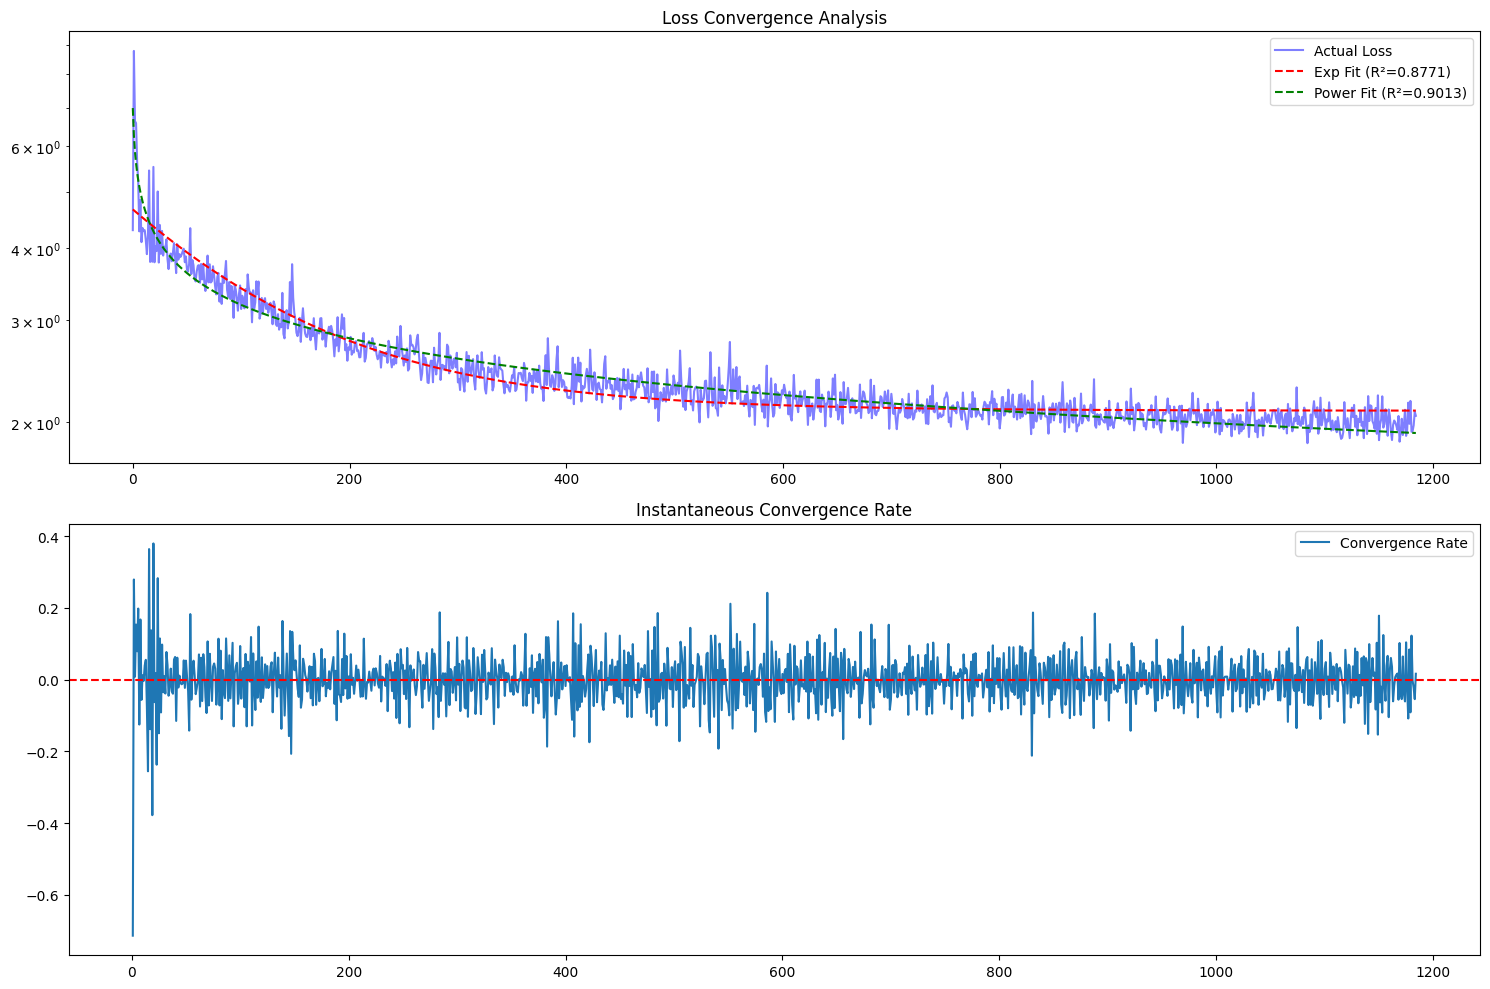

In [182]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def analyze_loss_convergence(losses):
    # Convert to numpy array if not already
    losses = np.array(losses)
    t = np.arange(len(losses))

    # Define potential fitting functions
    def exp_decay(t, a, b, c):
        return a * np.exp(-b * t) + c

    def power_law(t, a, b, c):
        return a / (t + 1)**b + c

    # Fit both models
    try:
        exp_params, _ = curve_fit(exp_decay, t, losses, p0=[losses[0], 0.01, losses[-1]])
        power_params, _ = curve_fit(power_law, t, losses, p0=[losses[0], 0.5, losses[-1]])

        # Calculate R-squared for both fits
        exp_fitted = exp_decay(t, *exp_params)
        power_fitted = power_law(t, *power_params)

        exp_r2 = 1 - np.sum((losses - exp_fitted)**2) / np.sum((losses - np.mean(losses))**2)
        power_r2 = 1 - np.sum((losses - power_fitted)**2) / np.sum((losses - np.mean(losses))**2)

        # Plot results
        plt.figure(figsize=(15, 10))

        # Original data
        plt.subplot(2, 1, 1)
        plt.plot(t, losses, 'b-', label='Actual Loss', alpha=0.5)
        plt.plot(t, exp_fitted, 'r--', label=f'Exp Fit (R²={exp_r2:.4f})')
        plt.plot(t, power_fitted, 'g--', label=f'Power Fit (R²={power_r2:.4f})')
        plt.yscale('log')
        plt.legend()
        plt.title('Loss Convergence Analysis')

        # Convergence rate
        plt.subplot(2, 1, 2)
        rates = -(np.diff(np.log(losses)))
        plt.plot(t[1:], rates, label='Convergence Rate')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Instantaneous Convergence Rate')
        plt.legend()

        # Print findings
        print(f"Exponential fit: L(t) = {exp_params[0]:.2f} * exp(-{exp_params[1]:.4f} * t) + {exp_params[2]:.2f}")
        print(f"Power law fit: L(t) = {power_params[0]:.2f} / (t+1)^{power_params[1]:.4f} + {power_params[2]:.2f}")
        print(f"\nMean convergence rate: {np.mean(rates):.4f}")
        print(f"Final loss value: {losses[-1]:.4f}")

        plt.tight_layout()
        plt.show()

    except RuntimeError:
        print("Fitting failed - try adjusting initial parameters")

analyze_loss_convergence(losses)

Adam Loss: 257.293213
Adam Loss: 255.505951
Adam Loss: 251.923126
Adam Loss: 257.594238
Adam Loss: 249.402328
Adam Loss: 254.079346
Adam Loss: 258.496490
Adam Loss: 254.154846
Adam Loss: 253.954941
Adam Loss: 257.978760
Adam Loss: 257.894043
Adam Loss: 252.953491
Adam Loss: 255.930283
Adam Loss: 251.477264
Adam Loss: 260.066559
Adam Loss: 250.558609
Adam Loss: 255.097656
Adam Loss: 251.773743
Adam Loss: 252.810043
Adam Loss: 248.626709
Adam Loss: 257.341217
Adam Loss: 251.037704
Adam Loss: 250.000168
Adam Loss: 252.628525
Adam Loss: 247.295013
Adam Loss: 246.031082
Adam Loss: 247.611374
Adam Loss: 251.780289
Adam Loss: 252.273376
Adam Loss: 251.706497
Adam Loss: 243.544144
Adam Loss: 252.396271
Adam Loss: 245.345276
Adam Loss: 245.716827
Adam Loss: 247.377151
Adam Loss: 246.747162
Adam Loss: 252.109055
Adam Loss: 246.796356
Adam Loss: 252.543625
Adam Loss: 244.873245
Adam Loss: 248.510010
Adam Loss: 244.167953
Adam Loss: 246.829315
Adam Loss: 246.181076
Adam Loss: 246.860336
Adam Loss:

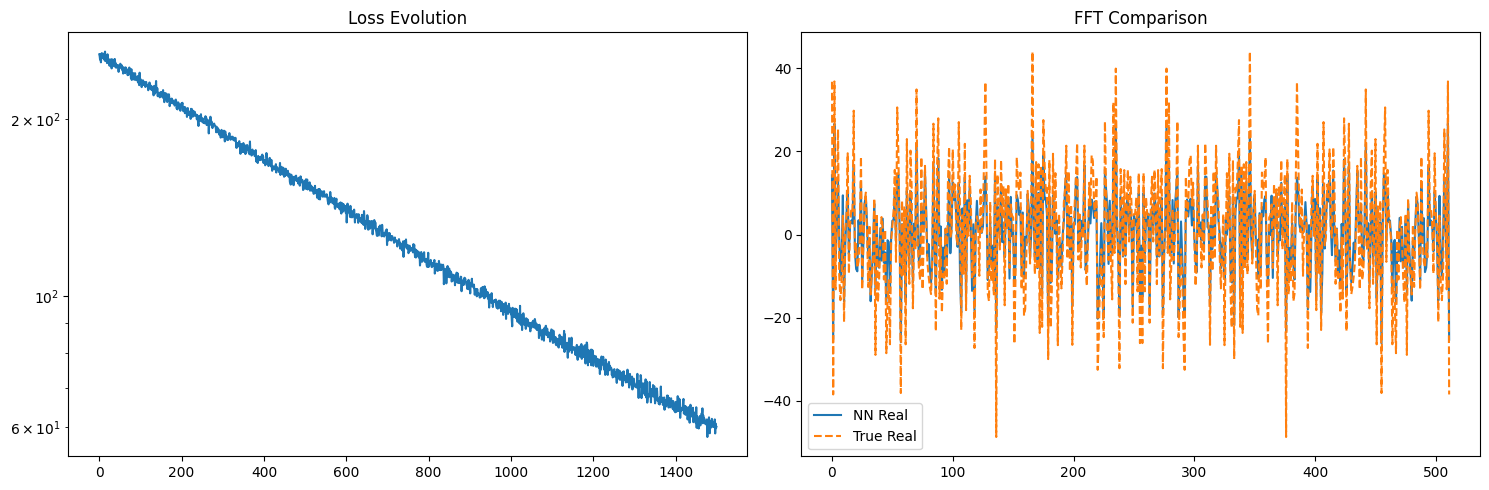

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class DFTNetwork(nn.Module):
   def __init__(self, input_size=512):
       super().__init__()
       self.layer1 = nn.Linear(input_size, input_size*2)
       self.layer2 = nn.Linear(input_size*2, input_size*2)

   def forward(self, x):
       x = self.layer1(x)
       x = torch.tanh(x)
       x = self.layer2(x)
       return x.view(x.shape[0], -1, 2)



# Two independent models
model_adam = DFTNetwork()
# Two optimizers
adam_opt = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
losses_adam = []
n_epochs = 1500

def generate_fft_data(batch_size=32):
    x = torch.randn(batch_size, 512)
    y = torch.fft.fft(x)
    return x, torch.stack((y.real, y.imag), dim=-1)

for epoch in range(n_epochs):
    x, y = generate_fft_data(batch_size=32)


    # Adam model on same data
    adam_opt.zero_grad()
    y_pred_adam = model_adam(x)
    loss_adam = torch.mean((y_pred_adam - y)**2)
    loss_adam.backward()
    adam_opt.step()
    losses_adam.append(loss_adam.item())
    print(f'Adam Loss: {losses_adam[-1]:.6f}')
    # Plot results

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(losses_adam)
plt.title('Loss Evolution')
plt.yscale('log')

plt.subplot(122)
with torch.no_grad():
   y_pred = model_adam(x)
plt.plot(y_pred[0,:,0].numpy(), label='NN Real')
plt.plot(y[0,:,0].numpy(), '--', label='True Real')
plt.title('FFT Comparison')
plt.legend()

plt.tight_layout()
plt.show()

sgd Loss: 260.098083
sgd Loss: 260.611511
sgd Loss: 252.059906
sgd Loss: 257.268250
sgd Loss: 257.189453
sgd Loss: 260.869263
sgd Loss: 257.100952
sgd Loss: 257.388214
sgd Loss: 257.285034
sgd Loss: 256.593964
sgd Loss: 255.642487
sgd Loss: 254.657135
sgd Loss: 258.632782
sgd Loss: 257.380890
sgd Loss: 251.586533
sgd Loss: 252.337555
sgd Loss: 259.157959
sgd Loss: 255.805969
sgd Loss: 257.608582
sgd Loss: 255.342224
sgd Loss: 253.291702
sgd Loss: 250.268494
sgd Loss: 257.488770
sgd Loss: 260.962830
sgd Loss: 257.047913
sgd Loss: 255.404938
sgd Loss: 253.734497
sgd Loss: 254.108521
sgd Loss: 252.095947
sgd Loss: 255.198318
sgd Loss: 258.074799
sgd Loss: 252.455109
sgd Loss: 259.950104
sgd Loss: 257.018494
sgd Loss: 257.286591
sgd Loss: 259.706512
sgd Loss: 256.031982
sgd Loss: 257.966461
sgd Loss: 252.559219
sgd Loss: 258.439697
sgd Loss: 257.562439
sgd Loss: 255.441956
sgd Loss: 256.121307
sgd Loss: 256.970886
sgd Loss: 262.988464
sgd Loss: 260.962250
sgd Loss: 257.324585
sgd Loss: 254

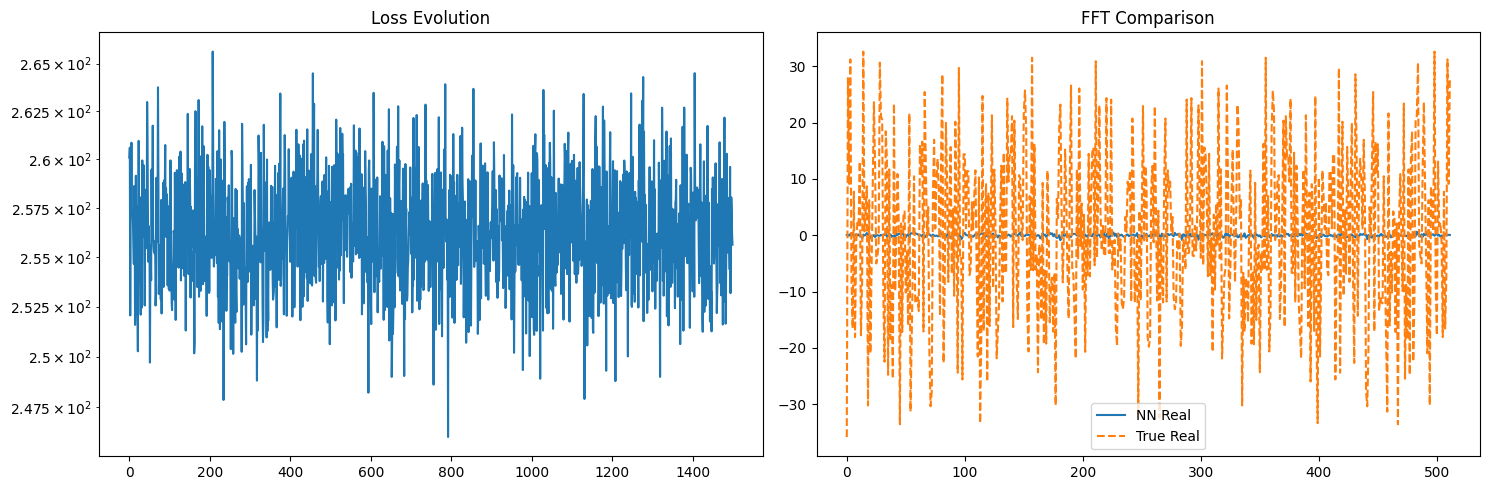

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class DFTNetwork(nn.Module):
   def __init__(self, input_size=512):
       super().__init__()
       self.layer1 = nn.Linear(input_size, input_size*2)
       self.layer2 = nn.Linear(input_size*2, input_size*2)

   def forward(self, x):
       x = self.layer1(x)
       x = torch.tanh(x)
       x = self.layer2(x)
       return x.view(x.shape[0], -1, 2)

class SGDOptimizer:
    def __init__(self, params, learning_rate=0.01):
        self.params = params  # list of parameters
        self.lr = learning_rate

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()  # set gradient to zero in-place
    def step(self):
        for p in self.params:
            if p.grad is not None:  # check if gradient exists
                p.data -= self.lr * p.grad  # basic SGD update step

model_sgd= DFTNetwork()
# Two optimizers
optim_sgd = SGDOptimizer(model_sgd.parameters(), learning_rate=1.0)
losses_sgd = []
n_epochs = 1500

def generate_fft_data(batch_size=32):
    x = torch.randn(batch_size, 512)
    y = torch.fft.fft(x)
    return x, torch.stack((y.real, y.imag), dim=-1)

for epoch in range(n_epochs):
    x, y = generate_fft_data(batch_size=32)


    # Adam model on same data
    optim_sgd.zero_grad()
    y_pred_sgd = model_sgd(x)
    loss_sgd = torch.mean((y_pred_sgd - y)**2)
    loss_sgd.backward()
    optim_sgd.step()
    losses_sgd.append(loss_sgd.item())
    print(f'sgd Loss: {losses_sgd[-1]:.6f}')
    # Plot results

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(losses_sgd)
plt.title('Loss Evolution')
plt.yscale('log')

plt.subplot(122)
with torch.no_grad():
   y_pred = model_sgd(x)
plt.plot(y_pred[0,:,0].numpy(), label='NN Real')
plt.plot(y[0,:,0].numpy(), '--', label='True Real')
plt.title('FFT Comparison')
plt.legend()

plt.tight_layout()
plt.show()